<a href="https://colab.research.google.com/github/LeonVillanueva/CoLab/blob/master/BiDirectional_LSTM_toxic_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading word vectors...
Found 400000 word vectors.
Loading in comments...
Found 210337 unique tokens.
Shape of data tensor: (159571, 100)
Filling pre-trained embeddings...
Building model...
Training model...
Epoch 1/5
998/998 [==============================] - 84s 81ms/step - loss: 0.0888 - accuracy: 0.9719 - val_loss: 0.0554 - val_accuracy: 0.9911
Epoch 2/5
998/998 [==============================] - 79s 79ms/step - loss: 0.0546 - accuracy: 0.9764 - val_loss: 0.0542 - val_accuracy: 0.9841
Epoch 3/5
998/998 [==============================] - 79s 80ms/step - loss: 0.0512 - accuracy: 0.9688 - val_loss: 0.0530 - val_accuracy: 0.9837
Epoch 4/5
998/998 [==============================] - 79s 80ms/step - loss: 0.0495 - accuracy: 0.9628 - val_loss: 0.0520 - val_accuracy: 0.9327
Epoch 5/5
998/998 [==============================] - 80s 80ms/step - loss: 0.0482 - accuracy: 0.9487 - val_loss: 0.0528 - val_accuracy: 0.9887


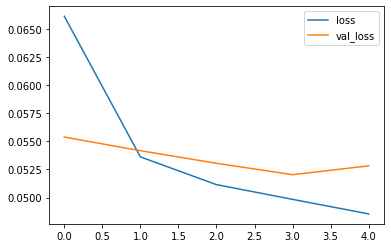

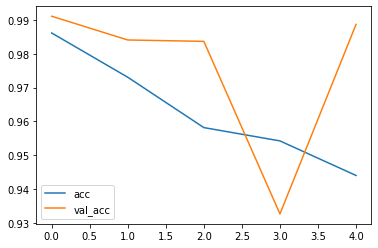

0.9807384589699414


In [9]:
# https://deeplearningcourses.com/c/deep-learning-advanced-nlp
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

import keras.backend as K
# if len(K.tensorflow_backend._get_available_gpus()) > 0:
#   from keras.layers import CuDNNLSTM as LSTM
#   from keras.layers import CuDNNGRU as GRU


# Download the data:
# https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge
# Download the word vectors:
# http://nlp.stanford.edu/data/glove.6B.zip


# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 5



# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('../content/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))



# prepare text samples and their labels
print('Loading in comments...')

train = pd.read_csv("../content/Toxic_NLP_train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values




# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)



# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))


# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)



# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector



# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)



print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# x = LSTM(15, return_sequences=True)(x)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy'],
)


print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))